Using TokaMaker to design a pulse in CUTE
==========
The purpose of this notebook is to a demonstrate pulse planning and control workflow for the CUTE tokamak in TokaMaker. It demonstrates concepts related to:
 - Computing coil currents required to produce a desired equilibrium
 - Defining and simulating a full plasma pulse using Spitzer resistivity
 - Demonstrating a simple control system for a vertical instability

Additional examples can be found as part of the documentation here: [https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/latest/doc_gs_main.html](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/latest/doc_gs_main.html)

## Setup Python environment

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

To load the TokaMaker python module we need to tell python where to the module is located. The best way to do this is through the `PYTHONPATH` environment variable or using a dedicated environement variable (eg. `OFT_ROOTPATH`) to provide the path to where the OpenFUSIONToolkit is installed and passing this to `sys.path.append()` as below.

It is also possible to run this script on Google Colab, which requires a few other steps including installing OFT from a binary tarball.

In [2]:
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    on_google_colab = True
except:
    tokamaker_python_path = os.getenv('OFT_ROOTPATH')
    if tokamaker_python_path is not None:
        sys.path.append(os.path.join(tokamaker_python_path,'python'))
    on_google_colab = False
    pass
else:
    !pip install -q wurlitzer ipympl
    OFT_package = 'OpenFUSIONToolkit_v1.0.0-beta6-Linux-GNU-x86_64'
    OFT_tarball = 'OpenFUSIONToolkit_v1.0.0-beta6-Ubuntu_22_04-GNU-x86_64.tar.gz'
    print("Google collab detected:")
    if os.path.exists(os.path.join('/content',OFT_package,'python')):
        print("  Using existing OFT installation")
    else:
        print("  Installing OFT for GitHub")
        !wget -q https://github.com/openfusiontoolkit/OpenFUSIONToolkit/releases/download/v1.0.0-beta6/{OFT_tarball}
        !tar xzf {OFT_tarball}
    OFT_rootpath = os.path.join('/content',OFT_package)
    !cp {OFT_rootpath}/examples/TokaMaker/CUTE/CUTE_mesh.h5 .
    sys.path.append(os.path.join(OFT_package,'python'))
    %load_ext wurlitzer
%matplotlib inline
%config InlineBackend.figure_format = "retina"

Now that TokaMaker is installed an in our Python path we can load the required modules

In [ ]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))

from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_power_flux_fun

## Setup model

### Initialize TokaMaker object
We now create a [OFT_env](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1__core_1_1OFT__env.html) instance for execution using two threads (one thread on colab) and a [TokaMaker](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html) instance to use for equilibrium calculations.

The `myOFT` instance is used to manage toolkit-wide environment elements and is passed to initialize individual physics tools such as TokaMaker or ThinCurr.

In [4]:
if on_google_colab:
    myOFT = OFT_env(nthreads=1)
else:
    myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          8905cc5
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/05/5bk04kj15rg64s4vd1hd6r0m0000gn/T/oft_12990/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Setup TokaMaker with CUTE mesh
Now we load the mesh generated in the [Building a mesh for CUTE example](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/doc_tMaker_CUTE_ex1.html) using [load_gs_mesh()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/namespaceOpenFUSIONToolkit_1_1TokaMaker_1_1meshing.html#aacb0f0d4ad8131d17461b7019dcd888f) and [setup_mesh](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a2f000ca8760eb886b9439ad30026c8d1). Next the [setup_regions()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#ad16d5039d91afc584a7c96dff8c8e1ed) method is used to define the different region types and corresponding physics, by passing the conductor and coil dictionaries for the mesh. Finally, we call [setup()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#aaa9d13419da15fd024f845b705ba94a8) to setup the required matrices and solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through $F_0$ = $B_0$*$R_0$, where $B_0$ (0.5 T) is the toroidal field at a reference location $R_0$ (0.34 m).

In [5]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('CUTE_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.settings.lim_zmax = 0.38 # Prevent limiting in upper/lower divertor areas
mygs.setup(order=2,F0=0.5*0.34)


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.301E+00
    # of points  =    5796
    # of edges   =   17283
    # of cells   =   11488
    # of boundary points =     102
    # of boundary edges  =     102
    # of boundary cells  =     102
  Resolution statistics:
    hmin =  3.994E-03
    hrms =  1.721E-02
    hmax =  7.410E-02
  Surface grounded at vertex     761


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.6960000000000000E-003


### Plot machine and computational mesh
After the previous series of calls the finite element representation is now initialized and linear operators (matrics) are computed corresponding to the desired physics equations in each region.
$$
\Delta^* \psi =
\begin{cases}
    -\frac{1}{2}\frac{\partial F^2}{\partial \psi} - \mu_0 R^2 \frac{\partial P}{\partial \psi} & \text{if } \textbf{r} \in \mathcal{P}\\
    -R \mu_0 J_{\phi} & \text{if } \textbf{r} \in \color{blue}{\mathcal{S}},\color{red}{\mathcal{C}} \\
    0 & \color{gray}{\text{elsewhere}}
\end{cases}
$$

This system is nonlinear in $\psi$ and is solved using a Picard (fixed-point) iteration for the first part of this example. Linear operators (eg. $\Delta^*$) are inverted using a sparse LU factorization package (eg. [UMFPACK](https://people.engr.tamu.edu/davis/suitesparse.html)).

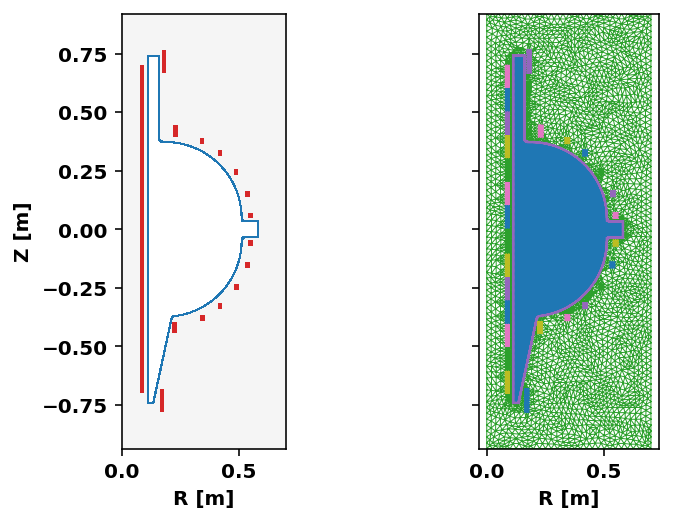

In [6]:
fig, ax = plt.subplots(1,2,sharey=True)
mygs.plot_machine(fig,ax[0],limiter_color=None,coil_color='tab:red',cond_color='tab:blue')
for i in range(mygs.reg.max()):
    ax[1].triplot(mygs.r[:,0],mygs.r[:,1],mygs.lc[mygs.reg==i+1,:],lw=0.5)
ax[1].set_aspect('equal','box')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
_ = ax[1].set_xlabel('R [m]')

## Compute target equilibrium

### Define hard limits on coil currents
Hard limits on coil currents can be set using [set_coil_bounds()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a59b44b96b90c8771e6ae6bd7dd51db14). For CUTE, all coils have a limit of 1 kA per turn.

Bounds are specified using a dictionary of 2 element lists, containing the minimum and maximum bound, where the dictionary key corresponds to the coil names, which are available in [mygs.coil_sets](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a2e2728d832365b8d197f8c36bccf675f)

In [7]:
coil_bounds = {key: [-1.E3, 1.E3] for key in mygs.coil_sets}
mygs.set_coil_bounds(coil_bounds)

### Define flux functions
Although TokaMaker has a "default" profile for the $FF'$ and $P'$ terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an L-mode-like profile of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, using [create_power_flux_fun()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/namespaceOpenFUSIONToolkit_1_1TokaMaker_1_1util.html#abaf2bb33d0f0943fce29b3c4ac5bd2da), where $\alpha$ and $\gamma$ are set differently for $FF'$ and $P'$ to provide peaked and broad profiles respectively. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

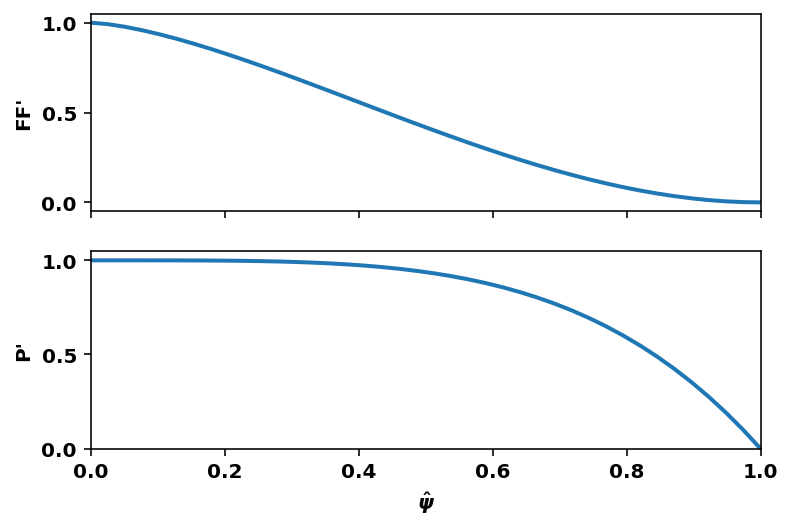

In [8]:
# Create profiles
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)

# Plot F*F' and P'
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
ax[-1].set_xlabel(r"$\hat{\psi}$")
ax[-1].set_xlim(0.0,1.0)
ax[-1].set_ylim(bottom=0.0)

# Set profiles
mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead [set_targets()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a07b6e3ba1ebe97531965538f7f7bedf4) should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the outboard side of the LCFS for the target equilibrium.

$$
\begin{matrix}
\textrm{Isoflux constraints} \\
\\
\textrm{Flux constraints} \\
\\
\textrm{Saddle constraints} \\
\\
\\
\end{matrix}
\begin{bmatrix}
\psi(r_1,C_1) - \psi(\bar{r}_1,C_1) & \cdots & \psi(r_1,C_m) - \psi(\bar{r}_1,C_m) \\
\cdots &  \cdots & \cdots \\
\psi(r_{n+1},C_1) & \cdots & \psi(r_{n+1},C_m) \\
\cdots &  \cdots & \cdots \\
\nabla_r \psi(r_{n+k+1},C_1) & \cdots & \nabla_r \psi(r_{n+k+1},C_m) \\
\nabla_z \psi(r_{n+k+1},C_1) & \cdots & \nabla_z \psi(r_{n+k+1},C_m) \\
\cdots &  \cdots & \cdots \\
\end{bmatrix}
\begin{bmatrix}
I_{C_1} \\
\cdots \\
I_{C_m} \\
\end{bmatrix}
=
\begin{bmatrix}
0 \\
\cdots \\
\bar{\psi}_1 \\
\cdots \\
0 \\
0 \\
\cdots \\
\end{bmatrix}
$$

In [9]:
# Define helper function for finding approximate limiting minor radius
lim_upper = np.flip(mygs.lim_contour[np.logical_and(mygs.lim_contour[:,0]>0.2,mygs.lim_contour[:,1]>0.06),:], axis=0)
def max_minor_rad(r0,kappa,delta,lim_pad=0.01):
    rmax = 0.5
    rmin = 0.115
    #
    a_from_r = min(r0 - rmin, rmax - r0)
    r_zmax = r0 + a_from_r * np.cos(np.pi/2.0 + np.arcsin(delta))
    zmax_lim = np.interp(r_zmax, lim_upper[:,0], lim_upper[:,1]) - lim_pad
    a_from_z = zmax_lim / kappa
    return min(a_from_z, a_from_r)

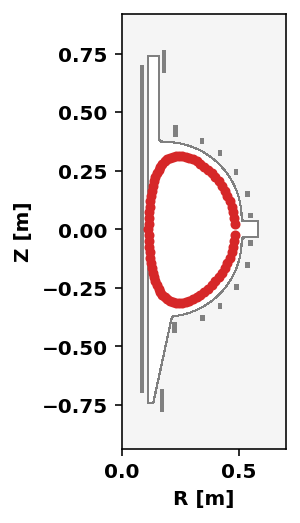

In [10]:
r0_flattop = 0.3
z0_flattop = 0.0
kappa_flattop = 1.7
delta_flattop = 0.3
a_flattop = max_minor_rad(r0_flattop,kappa_flattop,delta_flattop)
isoflux_pts = create_isoflux(80,r0_flattop,z0_flattop,a_flattop,kappa_flattop,delta_flattop)
mygs.set_isoflux(isoflux_pts)

# Plot targets
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')
ax.set_ylabel('Z [m]')
_ = ax.set_xlabel('R [m]')

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the coils. In TokaMaker these regularization terms have the general form, where each term corresponds to a set of coil coefficients, target value, and weight. The [coil_reg_term()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a9c18e8311dee1636f595e1119e9e7a8a) method is provided to aid in defining these terms.

Below we define two types of regularization targets:
 1. Targets that act to penalize up-down assymetry in up-down coil pairs, which are defined in the `coil_mirrors` dictionary.
 2. Targets the act to penalize the amplitude of current in each coil.

In the later case this regularization acts to penalize the amplitude of current in each coil, acting to balance coil currents with error in the shape targets. Additionally, this target is also used to "disable" several coils by setting the weight on their targets high to strongly penalize non-zero current.

$$
\begin{matrix}
\textrm{Isoflux constraints} \\
\\
\textrm{Flux constraints} \\
\\
\textrm{Saddle constraints} \\
\\
\\
\textrm{Regularization terms} \\
\\
\end{matrix}
\begin{bmatrix}
\psi(r_1,C_1) - \psi(\bar{r}_1,C_1) & \cdots & \psi(r_1,C_m) - \psi(\bar{r}_1,C_m) \\
\cdots &  \cdots & \cdots \\
\psi(r_{n+1},C_1) & \cdots & \psi(r_{n+1},C_m) \\
\cdots &  \cdots & \cdots \\
\nabla_r \psi(r_{n+k+1},C_1) & \cdots & \nabla_r \psi(r_{n+k+1},C_m) \\
\nabla_z \psi(r_{n+k+1},C_1) & \cdots & \nabla_z \psi(r_{n+k+1},C_m) \\
\cdots &  \cdots & \cdots \\
R_{1,1} & \cdots & R_{1,m} \\
\cdots &  \cdots & \cdots \\
\end{bmatrix}
\begin{bmatrix}
I_{C_1} \\
\cdots \\
I_{C_m} \\
\end{bmatrix}
=
\begin{bmatrix}
0 \\
\cdots \\
\bar{\psi}_1 \\
\cdots \\
0 \\
0 \\
\cdots \\
\bar{R}_1 \\
\cdots \\
\end{bmatrix}
$$

In [11]:
coil_mirrors = {'CS{0:02d}'.format(2*i+1): 'CS{0:02d}'.format(2*i+2) for i in range(7)}
coil_mirrors.update({'PF{0:02d}'.format(i): 'PF{0:02d}'.format(15-i) for i in range(1,8)})
disable_list = ['PF01']

# Set regularization weights
regularization_terms = []
for name, coil in mygs.coil_sets.items():
    if name not in coil_mirrors:
        continue
    if name in disable_list:
        # Set zero target current and high weight on coil and mirror
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E5))
        regularization_terms.append(mygs.coil_reg_term({coil_mirrors[name]: 1.0},target=0.0,weight=1.E5))
    else:
        # Set zero target current and small weight to help conditioning of fit
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E-1))
        # Set zero target for the difference of currents for coil and its mirror to ensure up-down symmetry
        regularization_terms.append(mygs.coil_reg_term({name: 1.0, coil_mirrors[name]: -1.0},target=0.0,weight=1.E0))

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

### Define global quantities and targets
For the Grad-Shafranov solve we define targets for the plasma current and the ratio the $FF'$ and $P'$ contributions to the plasma current, which is approximately related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$. In the scan below we will vary `Ip_ratio` to match different target $\beta$ values.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [12]:
Ip_flattop = 100.E3
beta_flattop = 0.3
mygs.set_targets(Ip=Ip_flattop,Ip_ratio=(1.0/beta_flattop - 1.0))

### Solve for target equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using [init_psi()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a617254ae65f4d9762aebc2c33bbb778c). This subroutine initializes the flux using the specified `Ip_target`, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation ($\kappa$) and triangularity ($\delta$). Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization.

[solve()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#abfde2f29e88af44e7f6778433eb3d403) is then called to compute a self-consitent Grad-Shafranov equilibrium. If the solve fails for one reason or another an exception will be raised.

In [13]:
mygs.init_psi(0.3,0.0,0.19,1.0,0.0)
mygs.solve()
psi0_flattop = mygs.get_psi(False)

Starting non-linear GS solver
     1  7.0825E-01  9.2355E-01  1.3605E-03  3.3023E-01 -2.6372E-06 -0.0000E+00
     2  8.2280E-01  9.8735E-01  3.9129E-04  3.2994E-01 -5.4266E-07 -0.0000E+00
     3  8.6962E-01  1.0120E+00  1.3338E-04  3.3006E-01 -2.1025E-06 -0.0000E+00
     4  8.9220E-01  1.0233E+00  5.6152E-05  3.3021E-01 -3.7614E-06 -0.0000E+00
     5  9.0358E-01  1.0288E+00  2.6755E-05  3.3033E-01 -5.0580E-06 -0.0000E+00
     6  9.0941E-01  1.0315E+00  1.3432E-05  3.3041E-01 -5.9196E-06 -0.0000E+00
     7  9.1242E-01  1.0329E+00  6.8868E-06  3.3046E-01 -6.4487E-06 -0.0000E+00
     8  9.1398E-01  1.0336E+00  3.5636E-06  3.3049E-01 -6.7720E-06 -0.0000E+00
     9  9.1479E-01  1.0339E+00  1.8522E-06  3.3050E-01 -6.9695E-06 -0.0000E+00
    10  9.1522E-01  1.0341E+00  9.6515E-07  3.3051E-01 -7.0905E-06 -0.0000E+00
 Timing:  0.30903999996371567     
   Source:    0.14772599982097745     
   Solve:      6.8176999688148499E-002
   Boundary:   5.2840004209429026E-003
   Other:      8.78530000336

### Plot target equilibrium
Flux surfaces of the computed equilibrium can be plotted using the [plot_psi()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#ad1b3ecfecf6f5e8c5ddd41202b3f0e07) method. The additional plotting methods [plot_machine()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a5b8d44b615d8240abf260f2bbd94a890) and [plot_constraints()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a77c95ffe127dc8ba9340f357b9572ae7) are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

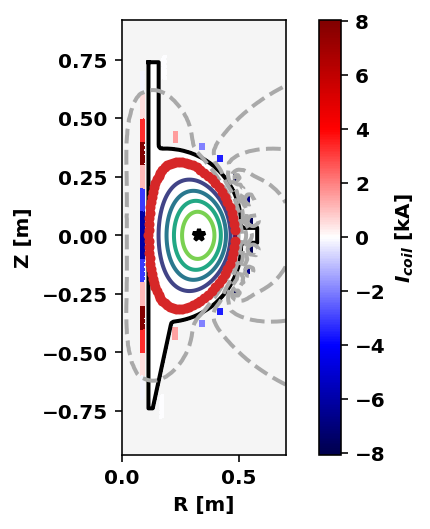

In [14]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=6,plasma_nlevels=6)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')
ax.set_ylabel('Z [m]')
_ =ax.set_xlabel('R [m]')

**Reminder on equations**

$$
    \Delta^* \psi =
\begin{cases}
    -\frac{1}{2}\frac{\partial F^2}{\partial \psi} - \mu_0 R^2 \frac{\partial P}{\partial \psi} & \text{if } \textbf{r} \in {\color{green}{\mathcal{P}}}\\
    0 & \text{if } \textbf{r} \in {\color{blue}{\mathcal{S}}}\\
    -R J_{\phi,\mathcal{C}_i} & \text{if } \textbf{r} \in {\color{red}{\mathcal{C}_i}}\\
    0 & \textbf{r} \in \mathcal{H} \setminus \left\{ {\color{green}{\mathcal{P}}}, {\color{blue}{\mathcal{S}}}, {\color{red}{\mathcal{C}}} \right\}
\end{cases}
$$

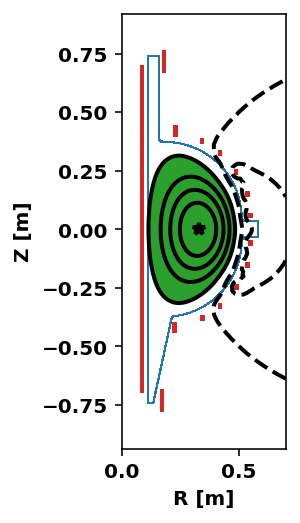

In [15]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None,coil_color='tab:red',cond_color='tab:blue',vacuum_color='white')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=3,plasma_nlevels=5,plasma_color='k',vacuum_color='k')
ax.tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc,mygs.get_psi(),levels=[-10.0,1.0],colors='tab:green')
ax.set_ylabel('Z [m]')
_ =ax.set_xlabel('R [m]')

## Define full scenario targets
To plan out a full pulse we now define representative time-dependent sequences for all required quantities. In this case we are just doing simple linear ramp-up and ramp-down of 10 ms each with a 40 ms flattop in between. We are assuming a 1 kA plasma after breakdown and are not including more detailed effects like flux consumption associated with breakdown. A simple density evolution is also defined to support evaluation of resistivity from the pressure profile.

In [16]:
Ip_breakdown = 1.E3
beta_breakdown = 0.1
scenario_targets = {
    'time': np.r_[0.0, 10.E-3, 60.E-3, 70.E-3],
    'Ip': np.r_[Ip_breakdown, Ip_flattop, Ip_flattop, Ip_breakdown],
    'kappa': np.r_[1.0, kappa_flattop, kappa_flattop, 1.0],
    'delta': np.r_[0.0, delta_flattop, delta_flattop, 0.0],
    'r0': np.r_[0.2, r0_flattop, r0_flattop, 0.2],
    'z0': np.r_[0.0, z0_flattop, z0_flattop, 0.0],
    'beta_approx': np.r_[beta_breakdown, beta_flattop, beta_flattop, beta_flattop*1.25],
    'density': np.r_[2.0E19, 2.5E19, 3.E19, 3.5E19]
}

### Plot scenario targets

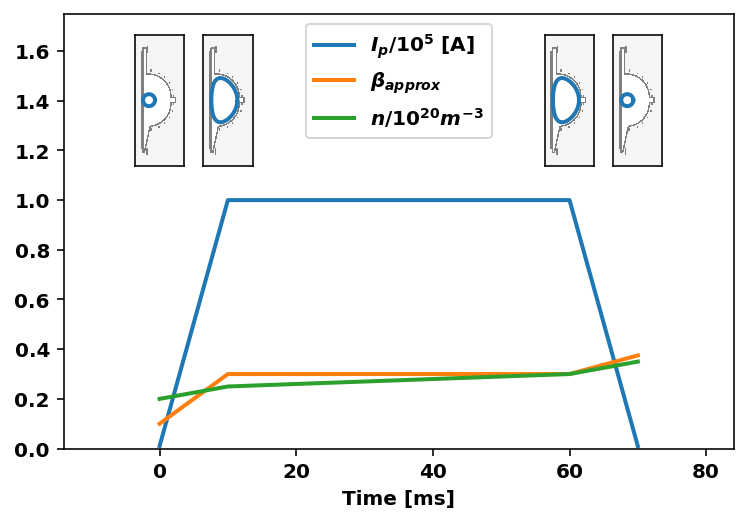

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1,1)
ax.plot(scenario_targets['time']*1.E3,scenario_targets['Ip']/1.E5,label=r'$I_p/10^5$ [A]')
ax.plot(scenario_targets['time']*1.E3,scenario_targets['beta_approx'],label=r'$\beta_{approx}$')
ax.plot(scenario_targets['time']*1.E3,scenario_targets['density']/1.E20,label=r'$n/10^{20} m^{-3}$')
ax.set_ylim(0.0,1.75)
t0 = scenario_targets['time'][0] - 0.2*(scenario_targets['time'][-1] - scenario_targets['time'][0])
t1 = scenario_targets['time'][-1] + 0.2*(scenario_targets['time'][-1] - scenario_targets['time'][0])
ax.set_xlim(t0*1.E3,t1*1.E3)
ax.legend(loc='upper center')
ax.set_xlabel('Time [ms]')

for i, shot_time in enumerate(scenario_targets['time']):
    rel_time = (shot_time-t0)/(t1-t0)
    inset_ax = ax.inset_axes([rel_time-.1, .65, .2, .3])
    mygs.plot_machine(fig, inset_ax, coil_colormap=None, limiter_color=None)
    r0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['r0'])
    z0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['z0'])
    kappa = np.interp(shot_time,scenario_targets['time'],scenario_targets['kappa'])
    delta = np.interp(shot_time,scenario_targets['time'],scenario_targets['delta'])
    a_current = max_minor_rad(r0,kappa,delta)
    isoflux_pts = create_isoflux(80, r0, z0, a_current, kappa, delta)
    inset_ax.plot(isoflux_pts[:,0],isoflux_pts[:,1])
    inset_ax.set_xticks([]); inset_ax.set_yticks([])

## Compute initial post-breakdown equilibrium
To initialize our scenario we compute an initial post-breakdown equilibrium with $I_p = 1$ kA and $\beta_p \approx = 10$% with a small circular, inboard-limited cross section.

In [18]:
mygs.set_targets(Ip=Ip_breakdown,Ip_ratio=(1.0/beta_breakdown - 1.0))

### Maximize transformer flux
To achieve the longest possible pulse length we want to start the pulse with the higher possible flux on the LCFS, which can be found by targetting a specific flux value and scanning until the maximum achievable value is found. For this example, we have already done this scan and just us a near-optimal value of 4.2 mWb/rad.

In [19]:
target_psi = 4.2E-3
isoflux_pts = create_isoflux(80,0.2,0.0,0.08,1.0,0.0)
mygs.set_isoflux(isoflux_pts, 1.E2*np.ones_like(isoflux_pts[:,0]))    # Target shape
mygs.set_flux(isoflux_pts, target_psi*np.ones_like(isoflux_pts[:,0])) # Target specific flux value

Additionally, we know that the maximum transformer flux will likely be achieved with the maximum possible current in all coils so we update our coil regularization to target this value instead of zero coil current.

In [20]:
# Set regularization weights
regularization_terms = []
for name, coil in mygs.coil_sets.items():
    if name not in coil_mirrors:
        continue
    if name in disable_list:
        # Set zero target current and high weight on coil and mirror
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E5))
        regularization_terms.append(mygs.coil_reg_term({coil_mirrors[name]: 1.0},target=0.0,weight=1.E5))
    else:
        # Set zero target current and small weight to help conditioning of fit
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=1.E3,weight=1.E-1))
        # Set zero target for the difference of currents for coil and its mirror to ensure up-down symmetry
        regularization_terms.append(mygs.coil_reg_term({name: 1.0, coil_mirrors[name]: -1.0},target=0.0,weight=1.E0))

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

### Solve for initial equilibrium
We can now compute a free-boundary equilibrium as above using [init_psi()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a617254ae65f4d9762aebc2c33bbb778c) and [solve()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#abfde2f29e88af44e7f6778433eb3d403).

**Note:** If scanning to find the maximum flux the solver will fail if the flux is too high and an exception will be raised.

In [21]:
mygs.init_psi(0.3,0.0,0.19,1.0,0.0)
mygs.solve()

Starting non-linear GS solver
     1  4.7689E-02  3.6274E-02  1.1731E-04  2.0845E-01 -7.7398E-06 -0.0000E+00
     2  5.5730E-02  3.8922E-02  3.0551E-05  2.0781E-01 -6.2441E-06 -0.0000E+00
     3  5.7900E-02  3.9559E-02  6.5689E-06  2.0759E-01 -5.8798E-06 -0.0000E+00
     4  5.8752E-02  3.9800E-02  1.3663E-06  2.0750E-01 -5.7770E-06 -0.0000E+00
     5  5.9109E-02  3.9899E-02  2.8724E-07  2.0747E-01 -5.7802E-06 -0.0000E+00
 Timing:  0.12655799998901784     
   Source:     5.0250999862328172E-002
   Solve:      2.8826000401750207E-002
   Boundary:   3.3849996980279684E-003
   Other:      4.4096000026911497E-002


### Plot initial equilibrium

psi_LCFS =    4.198E+00 [mWb/rad]


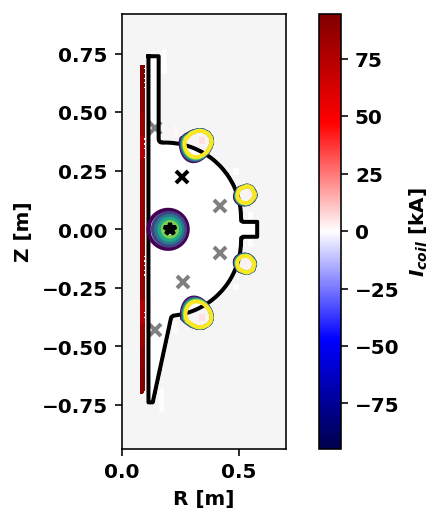

In [22]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=0,plasma_nlevels=6)
ax.set_ylabel('Z [m]')
ax.set_xlabel('R [m]')

lcfs_psi = mygs.psi_bounds[0]
print('psi_LCFS = {0:12.3E} [mWb/rad]'.format(lcfs_psi*1.E3))

## Compute full CUTE pulse
Now we move on to compute equilibria throughout the full plasma pusled defined by the target waveforms above.

### Define resistivity helper functions
In order to capture the flux consumption we need to define resistivity in the plasma, which we do with a simple Spitzer model. Here we define simple helper models that map from the equilibrium pressure profile to a resistivity profile under the assumption of constant density and $T_e/T_i$.

In [23]:
def spitzer_resistivity(n,T):
    def log_lambda(n,T):
        return 24.0-np.log(np.sqrt(n/1.E6)/T)
    return 5.253E-5*log_lambda(n,T)/np.power(T,1.5)

def te_from_p(p,n,te_edge=10.0,ti_frac=0.2):
    from OpenFUSIONToolkit.util import eC
    total_temp = p/(n*eC)
    Te = total_temp/(1.0+ti_frac)
    return Te + te_edge

def coil_vec2dict(self,currents):
    current_array = np.zeros((self.ncoils,), dtype=np.float64)
    for coil_key, coil_current in currents.items():
        current_array[self.coil_sets[coil_key]['id']] = coil_current
    return current_array

Here we demonstrate the use of these functions to compute the loop voltage required to maintain the initial post-breakdown equilibrium.

1.7963 [V]


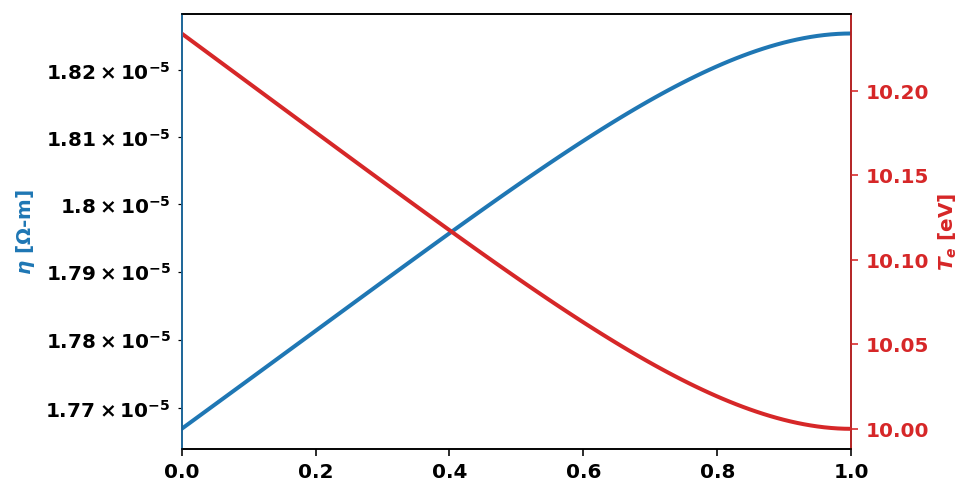

In [24]:
# Get temperature from pressure
psi_prof = np.linspace(0.0,1.0,100)
_,f,fp,p,pp = mygs.get_profiles(psi_prof)
density = scenario_targets['density'][0]
Te = te_from_p(p,density)
eta_prof = spitzer_resistivity(density,Te) # Spitzer resistivity

# Plot temperature and resistivity
fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.semilogy(psi_prof,eta_prof,'tab:blue')
ax2.plot(psi_prof,Te,'tab:red')
ax.set_ylabel(r'$\eta$ [$\Omega$-m]',color='tab:blue')
ax2.set_ylabel(r'$T_e$ [eV]',color='tab:red')
ax.tick_params(axis='y',color='tab:blue', labelcolor='tab:blue')
ax2.tick_params(color='tab:red', labelcolor='tab:red')
ax2.spines['left'].set_edgecolor('tab:blue')
ax2.spines['right'].set_edgecolor('tab:red')
ax.set_xlim(0.0,1.0)

# Set resistivity and get loop voltage
mygs.set_resistivity({'type': 'linterp', 'x': psi_prof, 'y': eta_prof})
loop_voltage = mygs.calc_loopvoltage()
print('{0:.5} [V]'.format(loop_voltage))

### Compute equilibria
No we can compute equilibria through the pulse by stepping in time. At each point we compute a new equilibrium subject to the target constraints, including an time-varying value of $\psi_{LCFS}$ that is determined by the time-varying loop voltage computed using Spitzer resistivity. Additionally, we also apply a simple regularizatino term that aims to limit changes in coil current between time points, which is a simple proxy for minimizing coil voltages.

In [25]:
# Disable iteration printing in solve
mygs.settings.pm=False
mygs.update_settings()

# Initialize previous step values
prev_coils, _ = mygs.get_coil_currents()
psi_target = mygs.psi_bounds[0]
last_time = 0
dt = 1.E-3

# Create storage arrays for timeseries data
frames = []
coil_hist = [coil_vec2dict(mygs,prev_coils),]
flux_hist = [[mygs.psi_bounds[0],mygs.psi_bounds[0]],]
volt_hist = []
Lcoils = mygs.get_coil_Lmat()

# Get initial flux
psi0 = mygs.get_psi(False)

# Run calculation over scenario
time_points = np.arange(0.0, scenario_targets['time'][-1], dt)
for step, shot_time in enumerate(time_points[1:]):
    # Compute new global targets at current time
    Ip = np.interp(shot_time,scenario_targets['time'],scenario_targets['Ip'])
    beta_approx = np.interp(shot_time,scenario_targets['time'],scenario_targets['beta_approx'])

    # Compute new shape targets at current time
    r0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['r0'])
    z0 = np.interp(shot_time,scenario_targets['time'],scenario_targets['z0'])
    kappa = np.interp(shot_time,scenario_targets['time'],scenario_targets['kappa'])
    delta = np.interp(shot_time,scenario_targets['time'],scenario_targets['delta'])
    density = np.interp(shot_time,scenario_targets['time'],scenario_targets['density'])
    a_current = max_minor_rad(r0,kappa,delta)

    # Update LCFS target from loop voltage
    dt = shot_time - last_time
    delta_psi = (loop_voltage * dt) / (2 * np.pi)
    psi_target -= delta_psi
    print(f"Step {step:3d}: psi_target = {psi_target:.2E} Ip={Ip:.2E}, kappa={kappa:.2f}, delta={delta:.2f}, a={a_current:.3f}")

    # Set updated targets
    mygs.set_targets(Ip=Ip,Ip_ratio=(1.0/beta_approx - 1.0))
    isoflux_pts = create_isoflux(80, r0, z0, a_current, kappa, delta)
    mygs.set_flux(isoflux_pts, psi_target*np.ones((isoflux_pts.shape[0],)))
    mygs.set_isoflux(isoflux_pts) # By including isoflux pts too, we add weight to making sure the shape is matched in addition to the desired flux

    # Update coil regularization using coil currents from previous step
    regularization_terms = []
    for name, coil in mygs.coil_sets.items():
        if name not in coil_mirrors:
            continue
        if name in disable_list:
            regularization_terms.append(mygs.coil_reg_term({name: 1.0}, target=0.0, weight=1.E5))
            regularization_terms.append(mygs.coil_reg_term({coil_mirrors[name]: 1.0}, target=0.0, weight=1.E5))
            continue
        else:
            weight = 2.E-2
            regularization_terms.append(mygs.coil_reg_term({name: 1.0}, target=prev_coils[name], weight=weight))
            regularization_terms.append(mygs.coil_reg_term({coil_mirrors[name]: 1.0}, target=prev_coils[coil_mirrors[name]], weight=weight))
    mygs.set_coil_reg(reg_terms=regularization_terms)

    # Solve for next equilibrium
    try:    # Compute new equilibrium
        mygs.set_psi_dt(psi0,dt) # ADDED: Set previous equilibrium as reference for eddy currents
        mygs.solve()
    except Exception as e:
        print("  WARNING: Step failed, {0}".format(str(e)))

    err_flag = mygs.solve()
    
    psi0 = mygs.get_psi(False) # ADDED: Update reference flux for next step

    # Compute coil voltages
    coil_currents, _ = mygs.get_coil_currents()
    volt_hist.append(np.dot(Lcoils[:-1,:-1],coil_vec2dict(mygs,coil_currents)-coil_vec2dict(mygs,prev_coils))/dt)

    # Save coil currents and boundary flux
    prev_coils = coil_currents.copy()
    coil_hist.append(coil_vec2dict(mygs,coil_currents))
    flux_hist.append([psi_target,mygs.psi_bounds[0]])

    # Update temperature, resistivity, and loop voltage
    psi_prof = np.linspace(0.0, 1.0, 100)
    _, f, fp, p, pp = mygs.get_profiles(psi_prof)
    Te = te_from_p(p, density)
    eta_prof = spitzer_resistivity(density, Te)
    mygs.set_resistivity({'type': 'linterp', 'x': psi_prof, 'y': eta_prof})
    loop_voltage = mygs.calc_loopvoltage()

    # Update previous time step
    last_time = shot_time

    # Create frame for animation
    fig, ax = plt.subplots(dpi=300,tight_layout=True)
    mygs.plot_machine(fig, ax, coil_colormap='seismic', coil_symmap=True, coil_scale=1e-3, coil_clabel=r'$I_{coil}$ [kA]', limiter_color=None)
    mygs.plot_psi(fig, ax, xpoint_color='k', vacuum_nlevels=0, plasma_nlevels=6)
    ax.plot(isoflux_pts[:, 0], isoflux_pts[:, 1], color='tab:red', label="Target LCFS")
    ax.set_title(r'$I_p$ ={0:4.0F} kA, $V_{{\phi}}$ ={1:4.2F} V, $t$ ={2:4.0F} ms'.format(Ip/1.E3,loop_voltage,shot_time*1.E3))
    ax.legend()
    ax.set_ylabel('Z [m]')
    ax.set_xlabel('R [m]')
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(image)
    plt.close(fig)

# Reenable iteration plotting
mygs.settings.pm=True
mygs.update_settings()

Step   0: psi_target = 3.91E-03 Ip=1.09E+04, kappa=1.07, delta=0.03, a=0.095
Step   1: psi_target = 3.24E-03 Ip=2.08E+04, kappa=1.14, delta=0.06, a=0.105
Step   2: psi_target = 2.89E-03 Ip=3.07E+04, kappa=1.21, delta=0.09, a=0.115
Step   3: psi_target = 2.68E-03 Ip=4.06E+04, kappa=1.28, delta=0.12, a=0.125
Step   4: psi_target = 2.54E-03 Ip=5.05E+04, kappa=1.35, delta=0.15, a=0.135
Step   5: psi_target = 2.43E-03 Ip=6.04E+04, kappa=1.42, delta=0.18, a=0.145
Step   6: psi_target = 2.35E-03 Ip=7.03E+04, kappa=1.49, delta=0.21, a=0.155
Step   7: psi_target = 2.28E-03 Ip=8.02E+04, kappa=1.56, delta=0.24, a=0.165
Step   8: psi_target = 2.22E-03 Ip=9.01E+04, kappa=1.63, delta=0.27, a=0.175
Step   9: psi_target = 2.17E-03 Ip=1.00E+05, kappa=1.70, delta=0.30, a=0.185
Step  10: psi_target = 2.13E-03 Ip=1.00E+05, kappa=1.70, delta=0.30, a=0.185
Step  11: psi_target = 2.08E-03 Ip=1.00E+05, kappa=1.70, delta=0.30, a=0.185
Step  12: psi_target = 2.03E-03 Ip=1.00E+05, kappa=1.70, delta=0.30, a=0.185

### Show animation of scenario
Uncomment this block of code to show an animation of the plasma pulse.

In [26]:
# from matplotlib import animation
# from IPython.display import HTML

# fig, ax = plt.subplots(tight_layout=True)
# ax.axis('off')
# ims = []
# for i, frame in enumerate(frames):
#     im = ax.imshow(frame, animated=True)
#     if i == 0:
#         ax.imshow(frame)  # show an initial one first
#     ims.append([im])

# ani = animation.ArtistAnimation(fig, ims, interval=250, blit=True)
# plt.close(fig)

# HTML(ani.to_jshtml())

### Compare target and realized $\psi_{LCFS}$

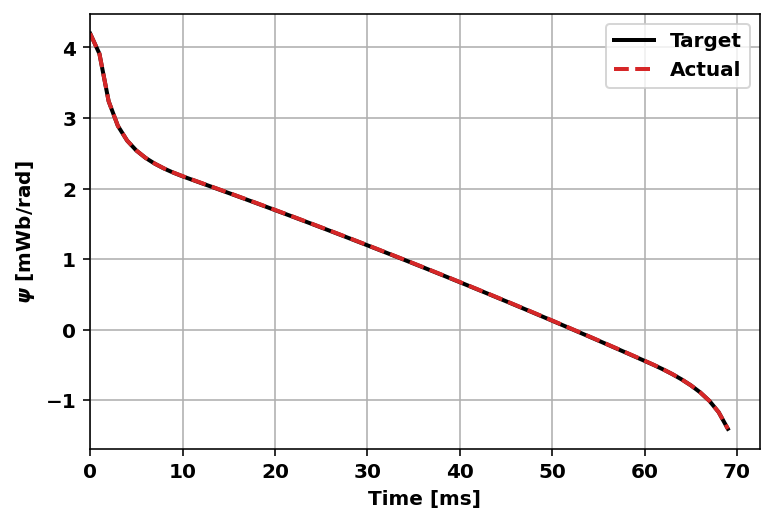

In [27]:
flux_hist = np.array(flux_hist)
fig, ax = plt.subplots(1,1)
ax.plot(time_points*1.E3,flux_hist[:,0]*1.E3,'k',label=r'Target')
ax.plot(time_points*1.E3,flux_hist[:,1]*1.E3,'--',color='tab:red',label=r'Actual')
ax.grid(True)
ax.set_xlim(left=0.0)
ax.set_xlabel('Time [ms]')
ax.set_ylabel(r'$\psi$ [mWb/rad]')
_ = ax.legend()

### Plot coil currents

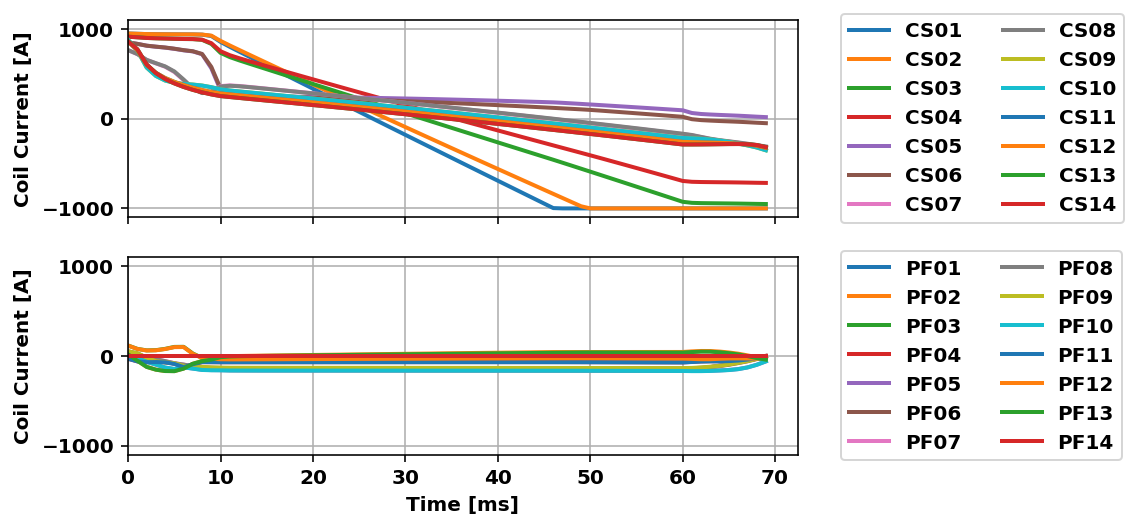

In [28]:
coil_hist = np.array(coil_hist)
fig, ax = plt.subplots(2,1,sharex=True)
for name, coil in mygs.coil_sets.items():
    if name.startswith('CS'):
        ax[0].plot(time_points*1.E3,coil_hist[:,coil['id']],label=name)
    if name.startswith('PF'):
        ax[1].plot(time_points*1.E3,coil_hist[:,coil['id']],label=name)
for ax_tmp in ax:
    ax_tmp.grid(True)
    ax_tmp.set_xlim(left=0.0)
    ax_tmp.set_ylim(-1.1E3,1.1E3)
    ax_tmp.set_ylabel('Coil Current [A]')
    ax_tmp.legend(ncols=2,loc='center left',bbox_to_anchor=(1.05, 0.5))
_ = ax[-1].set_xlabel('Time [ms]')

### Plot coil voltages

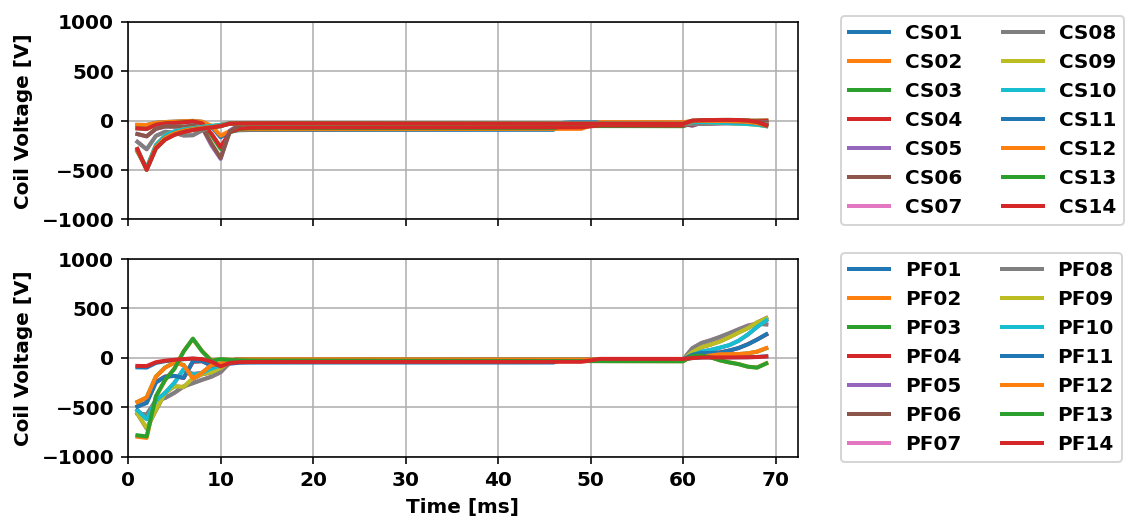

In [29]:
volt_hist = np.array(volt_hist)
fig, ax = plt.subplots(2,1,sharex=True)
for name, coil in mygs.coil_sets.items():
    if name.startswith('CS'):
        ax[0].plot(time_points[1:]*1.E3,volt_hist[:,coil['id']],label=name)
    if name.startswith('PF'):
        ax[1].plot(time_points[1:]*1.E3,volt_hist[:,coil['id']],label=name)
for ax_tmp in ax:
    ax_tmp.grid(True)
    ax_tmp.set_xlim(left=0.0)
    ax_tmp.set_ylim(-1.E3,1.E3)
    ax_tmp.set_ylabel('Coil Voltage [V]')
    ax_tmp.legend(ncols=2,loc='center left',bbox_to_anchor=(1.05, 0.5))
_ = ax[-1].set_xlabel('Time [ms]')

## Vertical control
Robustly achieving such a pulse in a real system requires an active control system, which can be developed in simulation before being tuned on the actual device. Here we demonstrate this process in a simplified case where we only consider vertical position control, which is necessary as sufficiently elongated equilibria are vertically unstable.

### Reset equilibrium to flattop target
To demonstrate control we will consider the period around the flattop equilibrium, which we recompute here to use as a starting point.

In [30]:
# Set regularization weights
regularization_terms = []
for name, coil in mygs.coil_sets.items():
    if name not in coil_mirrors:
        continue
    if name in disable_list:
        # Set zero target current and high weight on coil and mirror
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E5))
        regularization_terms.append(mygs.coil_reg_term({coil_mirrors[name]: 1.0},target=0.0,weight=1.E5))
    else:
        # Set zero target current and small weight to help conditioning of fit
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E-1))
        # Set zero target for the difference of currents for coil and its mirror to ensure up-down symmetry
        regularization_terms.append(mygs.coil_reg_term({name: 1.0, coil_mirrors[name]: -1.0},target=0.0,weight=1.E0))

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

isoflux_pts = create_isoflux(80,r0_flattop,z0_flattop,a_flattop,kappa_flattop,delta_flattop)
mygs.set_isoflux(isoflux_pts)
mygs.set_flux(None, None)
mygs.set_targets(Ip=Ip_flattop,Ip_ratio=(1.0/beta_flattop - 1.0))

mygs.set_psi_dt(psi0_flattop, 0.01)
mygs.init_psi(0.3,0.0,0.19,1.0,0.0)
mygs.solve()

coil_currents, _ = mygs.get_coil_currents()
psi0 = mygs.get_psi(False)


Starting non-linear GS solver
     1  7.0825E-01  9.2355E-01  1.3605E-03  3.3022E-01 -2.5925E-06 -0.0000E+00
     2  8.2282E-01  9.8743E-01  3.9085E-04  3.2994E-01 -5.5242E-07 -0.0000E+00
     3  8.6961E-01  1.0120E+00  1.3363E-04  3.3006E-01 -2.1167E-06 -0.0000E+00
     4  8.9219E-01  1.0233E+00  5.6313E-05  3.3022E-01 -3.7710E-06 -0.0000E+00
     5  9.0358E-01  1.0288E+00  2.6827E-05  3.3033E-01 -5.0629E-06 -0.0000E+00
     6  9.0941E-01  1.0315E+00  1.3462E-05  3.3041E-01 -5.9215E-06 -0.0000E+00
     7  9.1242E-01  1.0329E+00  6.8987E-06  3.3046E-01 -6.4489E-06 -0.0000E+00
     8  9.1398E-01  1.0336E+00  3.5680E-06  3.3049E-01 -6.7714E-06 -0.0000E+00
     9  9.1479E-01  1.0339E+00  1.8537E-06  3.3050E-01 -6.9686E-06 -0.0000E+00
    10  9.1522E-01  1.0341E+00  9.6551E-07  3.3051E-01 -7.0897E-06 -0.0000E+00
 Timing:  0.46867999993264675     
   Source:    0.13574599963612854     
   Solve:      6.6219999687746167E-002
   Boundary:   4.5190001837909222E-003
   Other:     0.262195000424

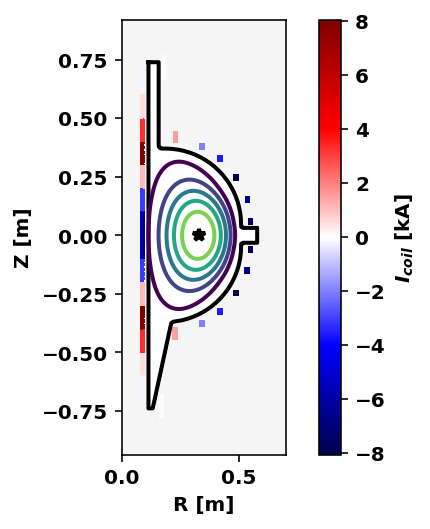

In [31]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=0,plasma_nlevels=6)
ax.set_ylabel('Z [m]')
_ = ax.set_xlabel('R [m]')

**Reminder on equations**

$$
    \Delta^* \psi =
\begin{cases}
    -\frac{1}{2}\frac{\partial F^2}{\partial \psi} - \mu_0 R^2 \frac{\partial P}{\partial \psi} & \text{if } \textbf{r} \in {\color{green}{\mathcal{P}}}\\
    -\frac{1}{\eta} \frac{\partial \psi}{\partial t} & \text{if } \textbf{r} \in {\color{blue}{\mathcal{S}}}\\
    -R J_{\phi,\mathcal{C}_i} & \text{if } \textbf{r} \in {\color{red}{\mathcal{C}_i}}\\
    0 & \textbf{r} \in \mathcal{H} \setminus \left\{ {\color{green}{\mathcal{P}}}, {\color{blue}{\mathcal{S}}}, {\color{red}{\mathcal{C}}} \right\}
\end{cases}
$$

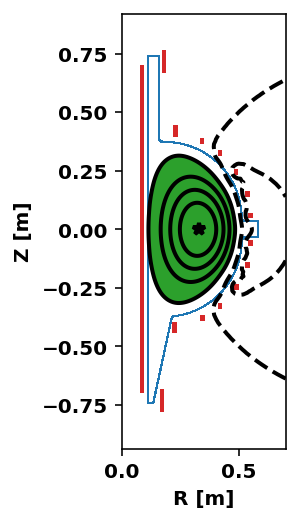

In [32]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None,coil_color='tab:red',cond_color='tab:blue',vacuum_color='white')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=3,plasma_nlevels=5,plasma_color='k',vacuum_color='k')
ax.tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc,mygs.get_psi(),levels=[-10.0,1.0],colors='tab:green')
ax.set_ylabel('Z [m]')
_ =ax.set_xlabel('R [m]')

### Linear stability of flattop equilibrium
The the linear stability properties of an equilbrium can be computed using [eig_td()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#ab125263be4da196ed8cb535f2af1cab3), which will provide a specified number of eigenmodes of the linearized system along with their eigenvalues, or growth rate. In this case, the most unstable mode corresponds to vertical instability, and has a growth rate of ~807 s^-1.

We also plot the vertically unstable mode and the eddy currents in conducting structures using the [plot_eddy()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#ac3576e95bbf630e754d25a96a20be6fc) method.

Growth rate = 7.4962E+03 [s]


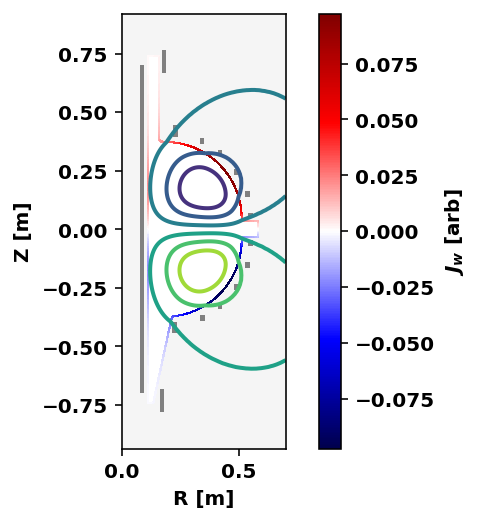

In [33]:
eig_vals, eig_vecs = mygs.eig_td(-1.E5,10,False)

# Plot unstable mode
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],xpoint_color=None,opoint_color=None,normalized=False)
mygs.plot_eddy(fig,ax,dpsi_dt=eig_vecs[0,:]/6.51E3,colormap='seismic',clabel=r'$J_w$ [arb]')
ax.set_ylabel('Z [m]')
ax.set_xlabel('R [m]')

print('Growth rate = {0:.4E} [s]'.format(-eig_vals[0,0]))

### Setup PID controller
For control we will use a simple PID algorithm to adjust the VSC current in response to an error in the vertical position as determined by the vertical location of the magnetic axis.

The controller will respect maximum current (as set above) and maximum voltage limits. Note that the inductance for the voltage limit is solely the self-inductance of the VSC coil and the voltage is loop voltage acting on one turn of the coil not the total voltage from lead to lead (need to multiply by `nTurns` for that).

In [34]:
P_gain = -3.E3
I_gain = -5.E1/1.E-5
D_gain = -24.E3*1.E-5
z0_thresh = 1.E-2
VSC_Vmax = 900*2 # Maximum voltage for VSC
VSC_coil = 'PF03'
VSC1_id = mygs.coil_sets[VSC_coil]['id']
VSC2_id = mygs.coil_sets[coil_mirrors[VSC_coil]]['id']
Lmat = mygs.get_coil_Lmat()
L_VSC = Lmat[VSC1_id,VSC1_id] - Lmat[VSC2_id,VSC1_id] - Lmat[VSC1_id,VSC2_id] + Lmat[VSC2_id,VSC2_id]

 Starting LU solver: umfpack F


### Set initial condition
Now the initial condition for the time-dependent simulation is set by taking the above equilibrium and adding a small perturbation based on the most unstable eigenmode computed above.

In [35]:
max_loc = abs(eig_vecs[0,:]).argmax()
psi_ic = psi0 - 0.0025*eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_vecs[0,max_loc]*np.sign(mygs.r[max_loc,1])
mygs.set_psi(psi_ic)

### Run simulation
The simulation is then run for 6 ms with a timestep of 30 us (200 steps) for the control loop. Longer timestep may often be used from a solver perspective, but the desired control cycle will often set the timestep size in control simulations.

The time-dependent simulation is initialized using [setup_td()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#afc5deed1d15721d7bc2aeda1006ecaaf) and then timesteps can be taken using [step_td()](https://openfusiontoolkit.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta6/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#aab4552268af309bf4b1e118ed700057f).

The controller is initially inactive and is only turned on once the displacement reaches a threshold and then is used to update the current in `PF03` and `PF12` (upper/lower PF coil pair) according to a simple PID algorithm for the rest of the simulation.

In [36]:
# Define time step size and plot/status frequency
dt = 30.E-6
nplot = 10
nstatus = 10
sim_time = 0.0

# Initialize history fields
results = []
z0 = [[sim_time,mygs.o_point[1]],]
vsc_vals = [[sim_time,coil_currents[VSC_coil]-coil_currents[coil_mirrors[VSC_coil]]],]

# Initialize previous step values
prev_coils, _ = mygs.get_coil_currents()

# Create storage arrays for timeseries data
frames = []
coil_hist = [coil_vec2dict(mygs,prev_coils),]
flux_hist = [[mygs.psi_bounds[0],mygs.psi_bounds[0]],]
volt_hist = []
Lcoils = mygs.get_coil_Lmat()

# Initialize control parameters
I_err = 0.0
z0_err_last = mygs.o_point[1]
control_on = False

# Setup time-dependent solver
mygs.settings.pm=False
mygs.update_settings()
mygs.set_isoflux(None)
mygs.set_saddles(None)
mygs.setup_td(15.E-6,1.E-13,1.E-11)

# Perform simulation
print('  Time     nl_its lin_its   stime     I_VSC')
t00 = time.perf_counter()
for i in range(200):
    # Perform time step
    t0 = time.perf_counter()
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    t1 = time.perf_counter()

    # Report status and save info for plotting
    VSC_curr = coil_currents[VSC_coil]-coil_currents[coil_mirrors[VSC_coil]]
    if i % nstatus == 0:
        print('{0:.2E}  {1:4d}    {2:4d}   {3:8.3f}   {4:7.2f}'.format(sim_time,nl_its,lin_its,t1-t0,VSC_curr))
    vsc_vals.append([sim_time,VSC_curr])
    z0.append([sim_time,mygs.o_point[1]])
    if i % nplot == 0:
        results.append(mygs.get_psi())

    # Turn on controller once we hit a certain threshold
    if abs(mygs.o_point[1]) > z0_thresh:
        control_on = True

    # If controller is on, use a simple PID algorithm with Z_0 and VSC
    if control_on:
        I_err = I_err + (z0_err_last + mygs.o_point[1])*dt/2.0
        new_curr = P_gain*mygs.o_point[1] + I_gain*I_err + D_gain*(mygs.o_point[1]-z0_err_last)/dt # Set target VSC current based on PID
        V_VSC = max(-VSC_Vmax,min(VSC_Vmax,L_VSC*(new_curr - (coil_currents[VSC_coil]-coil_currents[coil_mirrors[VSC_coil]]))/dt)) # Limit current based on voltage and coil inductance
        coil_currents[VSC_coil] += V_VSC*dt/L_VSC/2.0 # Update VSC current
        coil_currents[coil_mirrors[VSC_coil]] -= V_VSC*dt/L_VSC/2.0 # Update VSC current
        # Limit peak current if needed (not here)
        mygs.set_coil_currents(coil_currents) # Update coil currents for next time step

    # Update error for derivative term
    z0_err_last = mygs.o_point[1]
    
    # Compute coil voltages
    coil_currents, _ = mygs.get_coil_currents()
    volt_hist.append(np.dot(Lcoils[:-1,:-1],coil_vec2dict(mygs,coil_currents)-coil_vec2dict(mygs,prev_coils))/dt)

    # Save coil currents and boundary flux
    prev_coils = coil_currents.copy()
    coil_hist.append(coil_vec2dict(mygs,coil_currents))
    flux_hist.append([psi_target,mygs.psi_bounds[0]])


# Report total time
t1 = time.perf_counter()
print('Total solve time = {0:8.3f}'.format(t1-t00))

 Starting LU solver: umfpack F
  Time     nl_its lin_its   stime     I_VSC
3.00E-05     1       6      0.361     -0.57
3.30E-04     2      11      0.270     -0.57
6.30E-04     2      11      0.306     30.29
9.30E-04     1       6      0.201     -6.66
1.23E-03     1       6      0.186    -21.76
1.53E-03     1       6      0.165    -14.93
1.83E-03     1       5      0.153     -1.42
2.13E-03     1       5      0.160      6.38
2.43E-03     1       5      0.140      5.56
2.73E-03     1       5      0.155      0.77
3.03E-03     1       5      0.140     -2.75
3.33E-03     1       5      0.145     -3.12
3.63E-03     1       5      0.162     -1.53
3.93E-03     1       4      0.143     -0.03
4.23E-03     1       4      0.139      0.34
4.53E-03     1       4      0.136     -0.11
4.83E-03     1       4      0.134     -0.70
5.13E-03     1       3      0.102     -0.95
5.43E-03     1       4      0.123     -0.82
5.73E-03     1       3      0.104     -0.60
Total solve time =   30.585


### Plot evolution of flux surfaces

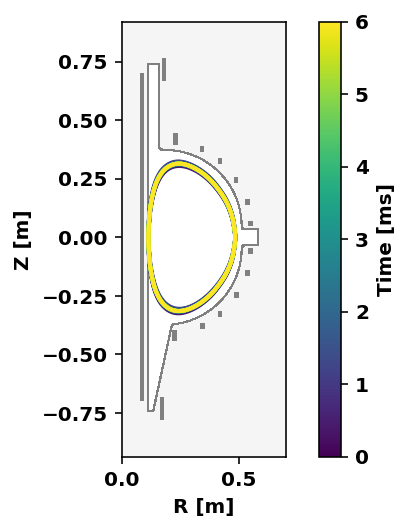

In [37]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
x=np.linspace(0.0,2*np.pi,100)
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax,psi=result,plasma_levels=[1.0],plasma_color=[colors[i]],vacuum_nlevels=0,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
_ = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis),ax=ax,label='Time [ms]')

### Plot vertical position and VSC current/voltage

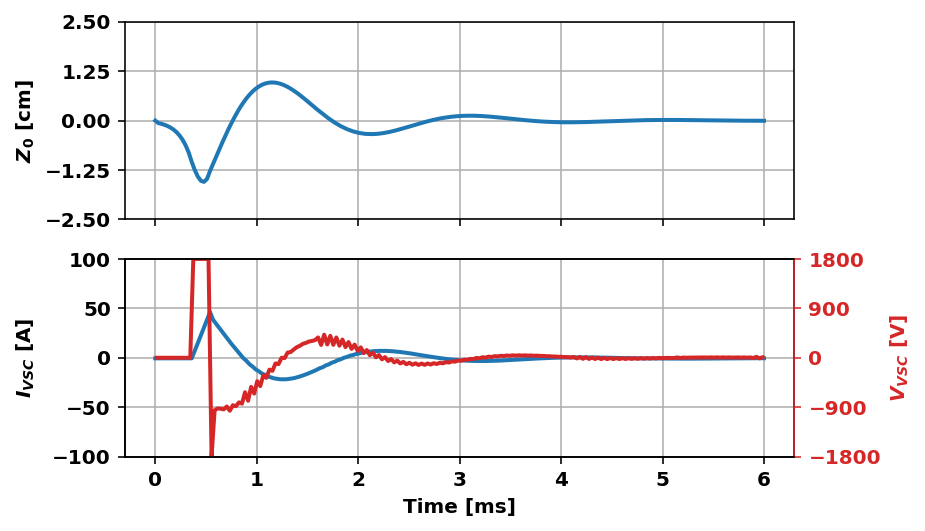

In [38]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(2,1,sharex=True)
z_hist = np.asarray(z0)
ax[0].plot(z_hist[:,0]*1.E3,z_hist[:,1]*100)
ax[0].set_ylabel(r'$Z_0$ [cm]')
ax[0].set_ylim(-2.5,2.5)
ax[0].yaxis.set_major_locator(ticker.LinearLocator(5))
ax[0].grid(True)

vsc_hist = np.asarray(vsc_vals)
ax[1].plot(vsc_hist[:,0]*1.E3,vsc_hist[:,1])
ax[1].set_ylabel(r'$I_{VSC}$ [A]')
ax[1].set_ylim(-100,100)
ax[1].yaxis.set_major_locator(ticker.LinearLocator(5))
ax[1].grid(True)
fig.align_ylabels()

ax_volt = ax[1].twinx()
ax_volt.plot((vsc_hist[1:,0]+vsc_hist[:-1,0])/2.0*1.E3,L_VSC*np.diff(vsc_hist[:,1])/np.diff(vsc_hist[:,0]),color='tab:red')
ax_volt.set_ylabel(r'$V_{VSC}$ [V]',color='tab:red')
ax_volt.spines['right'].set_color('tab:red')
ax_volt.tick_params(axis='y', colors='tab:red')
ax_volt.set_ylim(-VSC_Vmax,VSC_Vmax)
ax_volt.yaxis.set_major_locator(ticker.LinearLocator(5))
_ = ax[-1].set_xlabel(r'Time [ms]')

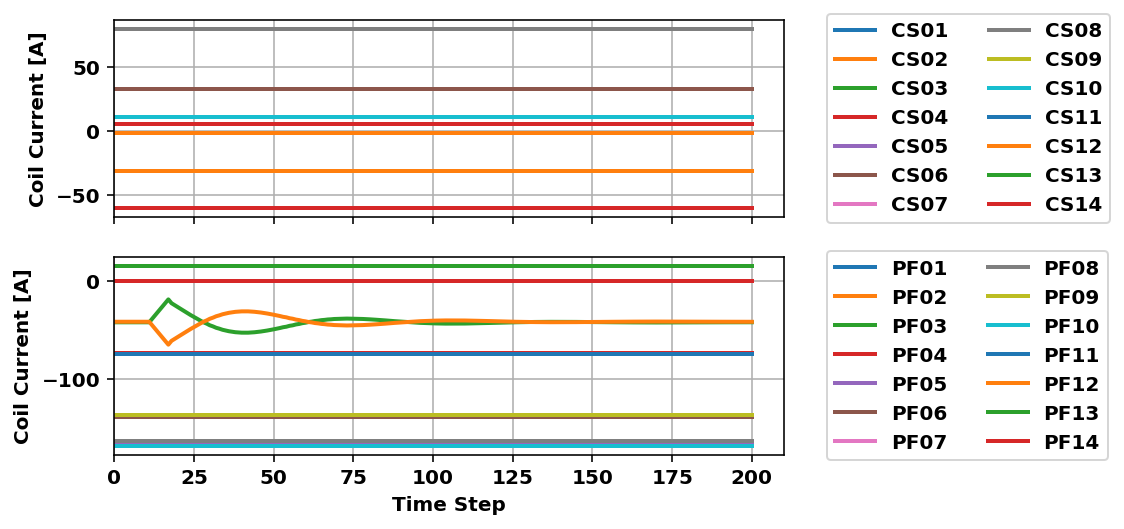

In [ ]:
coil_hist = np.array(coil_hist)
fig, ax = plt.subplots(2,1,sharex=True)
for name, coil in mygs.coil_sets.items():
    if name.startswith('CS'):
        ax[0].plot(coil_hist[:,coil['id']],label=name)
    if name.startswith('PF'):
        ax[1].plot(coil_hist[:,coil['id']],label=name)
for ax_tmp in ax:
    ax_tmp.grid(True)
    ax_tmp.set_xlim(left=0.0)
    ax_tmp.set_ylabel('Coil Current [A]')
    ax_tmp.legend(ncols=2,loc='center left',bbox_to_anchor=(1.05, 0.5))
_ = ax[-1].set_xlabel('Time Step')